# Predictive Analysis
### Predicting if the employee is salaried or not

To accomplish this task I created the sql server on Microsoft Azure and connecting it using python to extract data from table 'AdventureWorks2012.HumanResources.Employees' 

** Importing Required Libraries **

In [1]:
import numpy as np
import pandas as pd
import pyodbc
import time
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats.stats import pearsonr
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score,confusion_matrix
from sklearn.cross_validation import ShuffleSplit
from sklearn import svm, grid_search, datasets
from sklearn.grid_search import GridSearchCV
from sklearn import cross_validation
from sklearn.svm import SVC
from sklearn.learning_curve import learning_curve

** Initiating Functions that are used in this notebook **

In [2]:
# Function for plotting learning curves
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
   
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt




In [3]:
# Function to calculate number of days till today 
def calculate_days(y):
    today = datetime.datetime.now()
    days = (today - datetime.datetime.strptime(y, "%Y-%m-%d")).days
    return days

** Data Collection **

Fetching data from sql server table 'AdventureWorks2012.HumanResources.Employees' to python data frame(df)

In [4]:
# Connecting to sql server svarmitsql16 for extracting data
# Mentioning password is aganinst privacy however, I created this server only for this task so exposing password here.
cnn = pyodbc.connect('DRIVER={SQL Server};SERVER=svarmitsql16;PORT=1433;DATABASE=AdventureWorks2012;UID=SvarmitSQLDB;PWD=svarmit1987')


In [5]:
# Extracting all the rows from the table to python data frame(df) using pandas standard read_sql command
sql = 'select * from AdventureWorks2012.HumanResources.Employee;'
df = pd.read_sql(sql, cnn,coerce_float = True)

In [6]:
# Printing top 3 rows of data frame
df.head(n=3)

,BusinessEntityID,NationalIDNumber,LoginID,OrganizationNode,OrganizationLevel,JobTitle,BirthDate,MaritalStatus,Gender,HireDate,SalariedFlag,VacationHours,SickLeaveHours,CurrentFlag,rowguid,ModifiedDate
0,1,295847284,adventure-works\ken0,[],0,Chief Executive Officer,1963-03-02,S,M,2003-02-15,True,99,69,True,F01251E5-96A3-448D-981E-0F99D789110D,2008-07-31
1,2,245797967,adventure-works\terri0,[88],1,Vice President of Engineering,1965-09-01,S,F,2002-03-03,True,1,20,True,45E8F437-670D-4409-93CB-F9424A40D6EE,2008-07-31
2,3,509647174,adventure-works\roberto0,"[90, 192]",2,Engineering Manager,1968-12-13,M,M,2001-12-12,True,2,21,True,9BBBFB2C-EFBB-4217-9AB7-F97689328841,2008-07-31


** Data Analysis **

Before applying any predictive model it is very important to understand, clean(if required) and prepare data

In [7]:
# Printing the info of data to see details of data and columns
print (df.info())
print ('Data Frame Shape = ',df.shape) # Pring the shape of data (Rows,Columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290 entries, 0 to 289
Data columns (total 16 columns):
BusinessEntityID     290 non-null int64
NationalIDNumber     290 non-null object
LoginID              290 non-null object
OrganizationNode     290 non-null object
OrganizationLevel    290 non-null int64
JobTitle             290 non-null object
BirthDate            290 non-null object
MaritalStatus        290 non-null object
Gender               290 non-null object
HireDate             290 non-null object
SalariedFlag         290 non-null bool
VacationHours        290 non-null int64
SickLeaveHours       290 non-null int64
CurrentFlag          290 non-null bool
rowguid              290 non-null object
ModifiedDate         290 non-null datetime64[ns]
dtypes: bool(2), datetime64[ns](1), int64(4), object(9)
memory usage: 32.4+ KB
None
('Data Frame Shape = ', (290, 16))


** Data Cleaning and modification(if required) **

Following actions are taken on the data,

* Removing ModifiedDate and rowguid, as these are database specific and are not features attributing to prediction of salaried flag

* Converting Birthdate to age(days) and Hiredate to days since hiring(days). This does not change any meaning however being numeric it is easy to use in predictive models if required. However in this task I am not using date features 

* Converting string boolean to integer boolean (Salaried Flag and current Flag)

* Although NationalIDNumber will not be used as feature in this task then also converting NationalIDNumber to integer, as data looks like to be integer but imported from sql server as object. 

In [8]:
# Removing ModifiedDate and rowguid
df = df.iloc[:,:-2]
print ('Data Frame shape after removing 2 not required columns',df.shape)

('Data Frame shape after removing 2 not required columns', (290, 14))


In [9]:
# Conversion of Birthdate and Hiredate to number of days till now and conversion to integer datatype
df['HireDate'] = (df['HireDate'].map(lambda x: calculate_days(x))).astype(int) # Hire date to number to days since hired
df['age'] = (df['BirthDate'].map(lambda x: calculate_days(x))).astype(int)

In [10]:
# Converting string boolean to int boolean
df['SalariedFlag'] = df['SalariedFlag']*1
df['CurrentFlag'] = df['CurrentFlag']*1

In [11]:
# Changing NationalIDNumber's datatype to integer
df['NationalIDNumber'] = df['NationalIDNumber'].astype(int,raise_on_error=True)

In [12]:
# Printing info of data frame to confirm the above changes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290 entries, 0 to 289
Data columns (total 15 columns):
BusinessEntityID     290 non-null int64
NationalIDNumber     290 non-null int32
LoginID              290 non-null object
OrganizationNode     290 non-null object
OrganizationLevel    290 non-null int64
JobTitle             290 non-null object
BirthDate            290 non-null object
MaritalStatus        290 non-null object
Gender               290 non-null object
HireDate             290 non-null int32
SalariedFlag         290 non-null int32
VacationHours        290 non-null int64
SickLeaveHours       290 non-null int64
CurrentFlag          290 non-null int32
age                  290 non-null int32
dtypes: int32(5), int64(4), object(6)
memory usage: 28.4+ KB


** Understanding Data **
* Scatter Matrix
* Descriptive analyis
* Analysis of categorial features

Plotting Scatter matrix to visualize the trend of all the feature vs all other features. Blue Color indecates Not Salaried and Green Color sindecates Salaried 

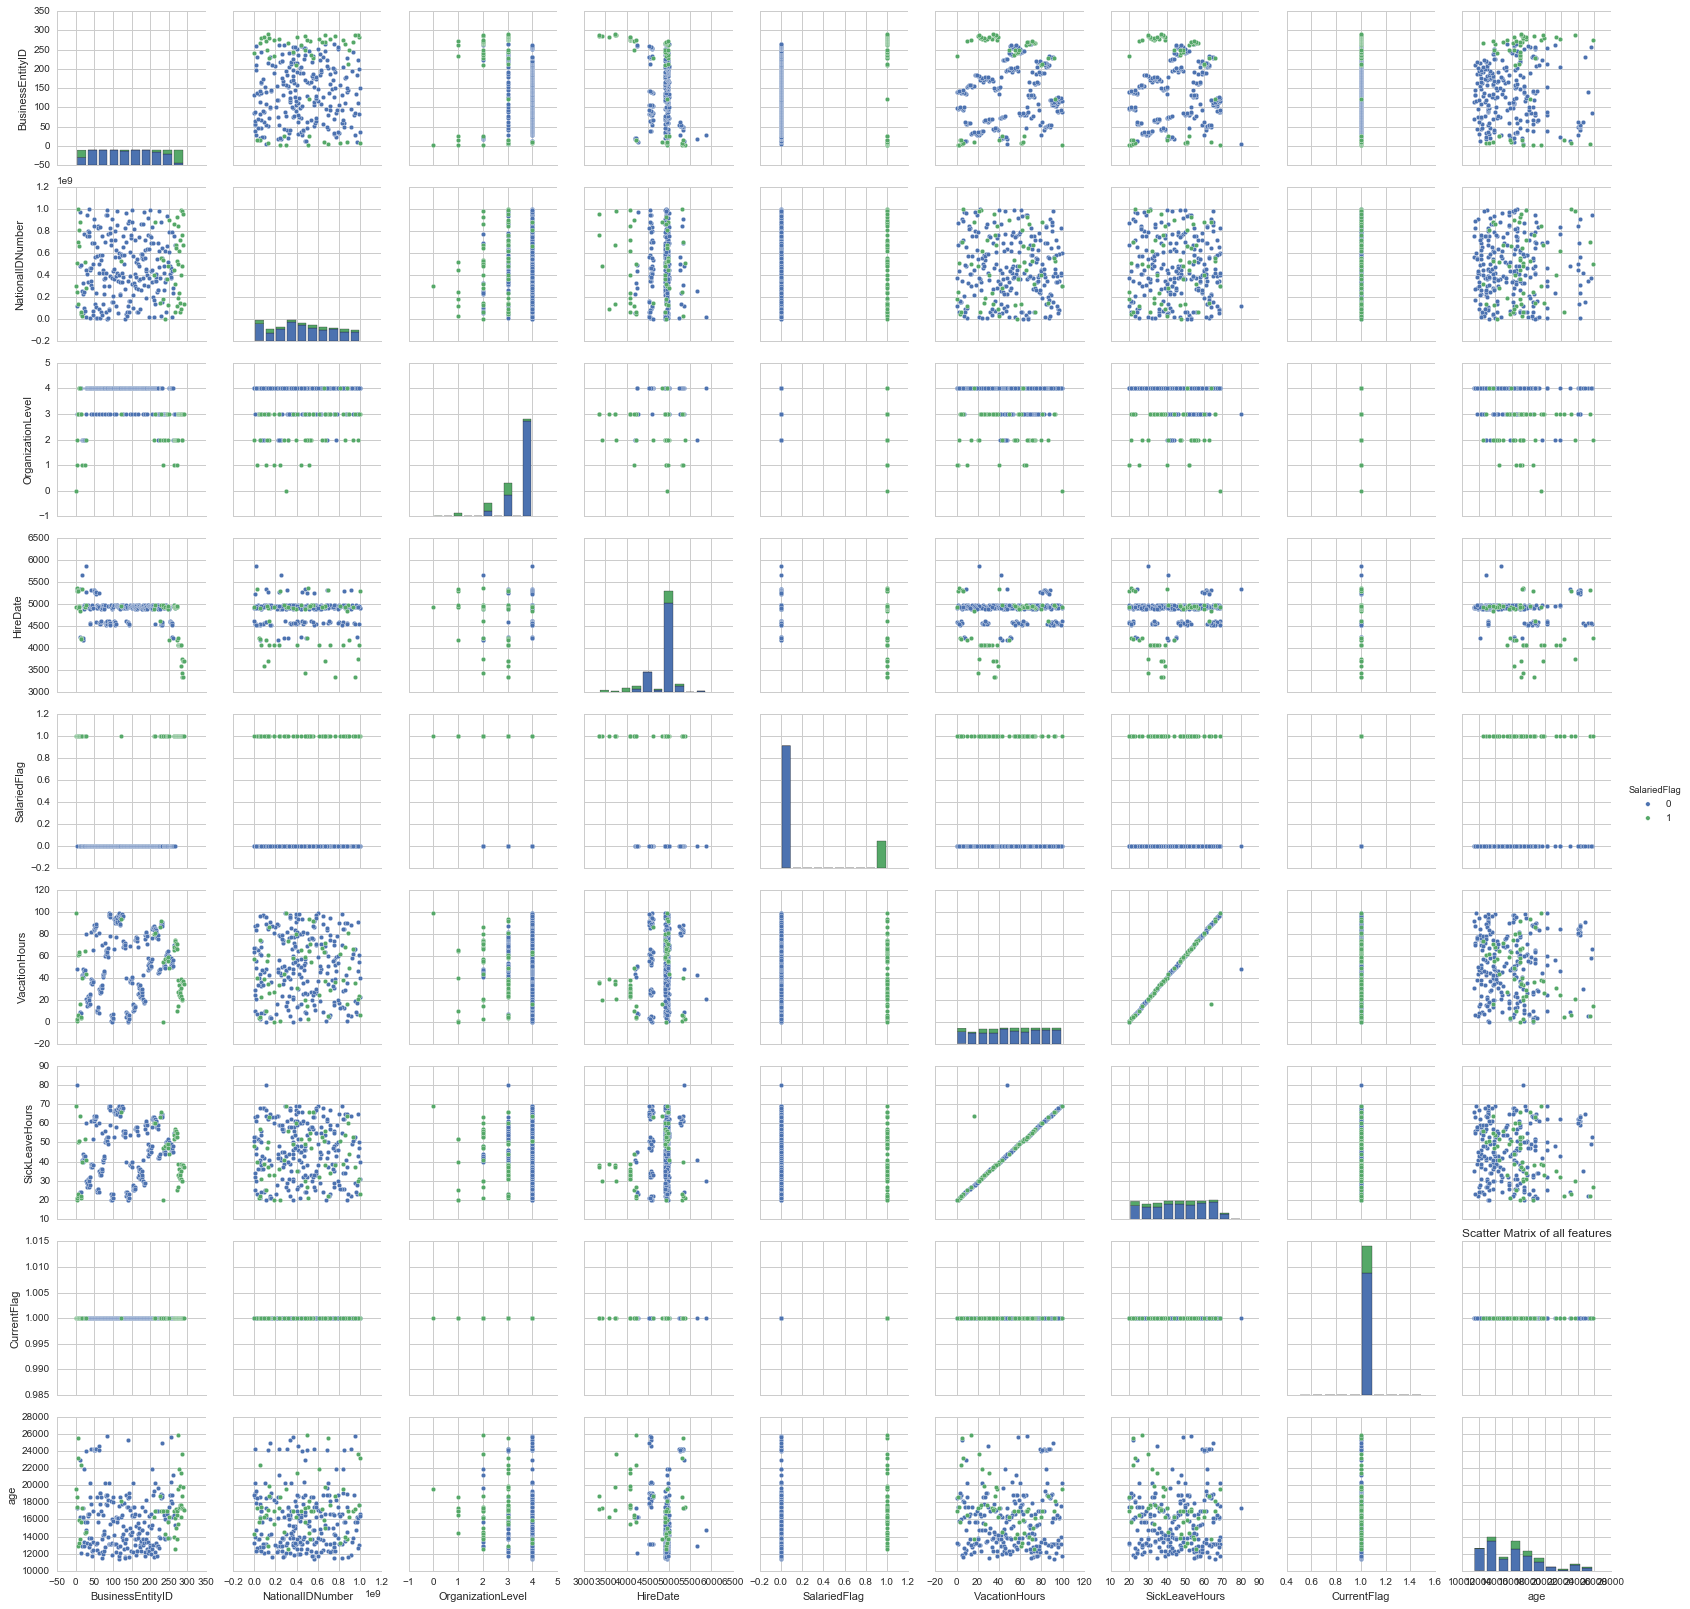

In [13]:
# plotting scatter matrix for data frame using salaried flag for color distribution of plot
sns.pairplot(df, hue = "SalariedFlag")
plt.title('Scatter Matrix of all features')

In [14]:
# Descriptive statistics of the int data tyep features (business entity, organization level, vacation hours and sickleave hours)
print (df.describe())

       BusinessEntityID  NationalIDNumber  OrganizationLevel     HireDate  \
count        290.000000      2.900000e+02         290.000000   290.000000   
mean         145.500000      4.616434e+08           3.510345  4822.751724   
std           83.860002      2.819121e+08           0.776981   334.691956   
min            1.000000      3.084500e+04           0.000000  3351.000000   
25%           73.250000      2.426168e+08           3.000000  4679.250000   
50%          145.500000      4.407119e+08           4.000000  4929.000000   
75%          217.750000      6.898923e+08           4.000000  4966.750000   
max          290.000000      9.994406e+08           4.000000  5877.000000   

       SalariedFlag  VacationHours  SickLeaveHours  CurrentFlag           age  
count    290.000000     290.000000      290.000000        290.0    290.000000  
mean       0.179310      50.613793       45.306897          1.0  16129.275862  
std        0.384275      28.786215       14.540444          0.0   

Above is the descriptive statistics of non object data type columns/features. Below is the understanding of data 

BusinessEntityId is the unique identifier for each data point. So this should not be used as feature for prediction.

Organization level ranges from 0-4 with the mean of 3.5 that implies the distribution of employees on organization level can be skewed.(Figure Below)

Vacation hours seems like distributed evenly across the data as it ranges from 0-99 with mean of 50 (figure below)

Sick hours might be skewed trend with range 20-80 and mean as 45 (Figure Belwo)

National id does not have any trend  so  seems like some random id assigned to employees (Similar to BusinessEntityId this should not be used as feature for predictive model )

Age and Hire date seems to be evenly distributed. Plotting these features will give beter idea. (Figures below)

(0, 5)

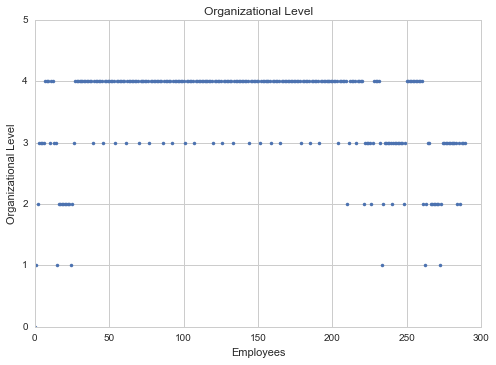

In [15]:
# plot of spread of  organization level
plt.plot(df['OrganizationLevel'],'.')
plt.ylabel('Organizational Level')
plt.xlabel('Employees')
plt.title('Organizational Level')
plt.ylim(0,5)

Most dense is  organization level 4 where as level 1 is very less

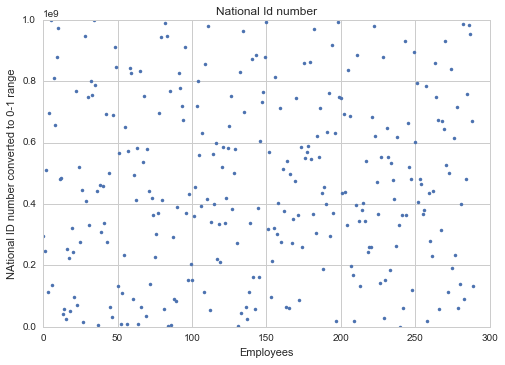

In [16]:
# plot of distribution of National Id number
plt.plot(df['NationalIDNumber'],'.')
plt.xlabel('Employees')
plt.ylabel('NAtional ID number converted to 0-1 range')
plt.title('National Id number')

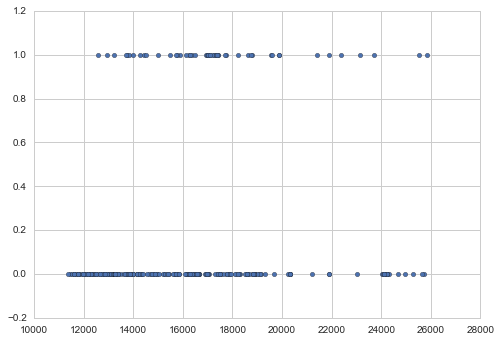

In [17]:
# Plot of age and days since hired on employees
plt.scatter(df['age'],df['SalariedFlag'])

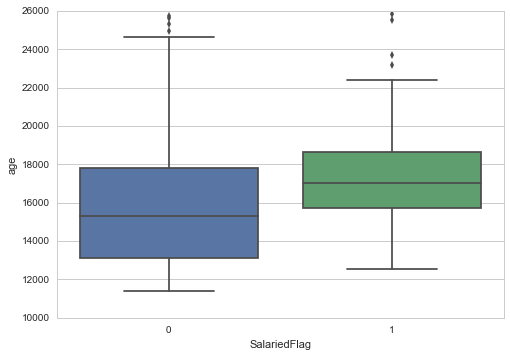

In [18]:
#Box plot of age and Salaried Flag
ax = sns.boxplot(y="age", x="SalariedFlag", data=df)

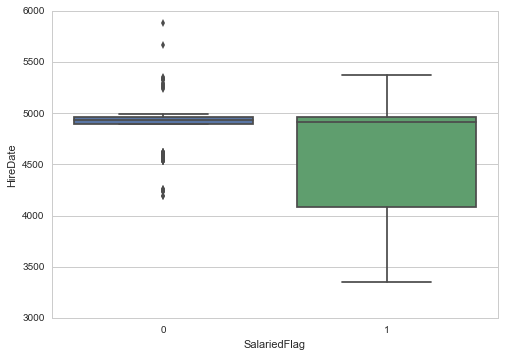

In [19]:
#Box plot of Hiredate and Salaried Flag
ax = sns.boxplot(y="HireDate", x="SalariedFlag", data=df)

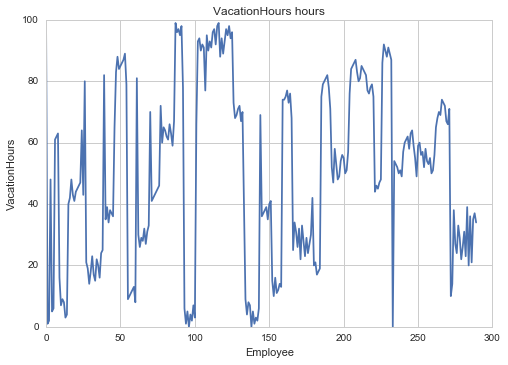

In [20]:
# plot of vacation hours on employees
plt.plot(df['VacationHours'])
plt.xlabel('Employee')
plt.ylabel('VacationHours')
plt.title('VacationHours hours')

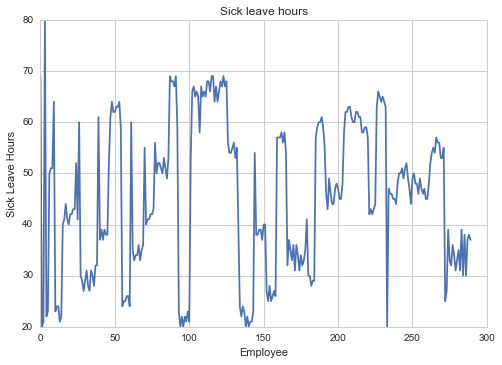

In [21]:
# plot of distribution of Sick leave hours on employees

plt.plot(df['SickLeaveHours'])
plt.xlabel('Employee')
plt.ylabel('Sick Leave Hours')
plt.title('Sick leave hours')

Distribution of Sick leave hours and the Vacation hours looks very simmilar. The difference visible is that sick leave hours have min = 0 and vacation hours have min = 20

Both features seems to be correlated, calculating pearson correlation score ('measure of the linear correlation between two variables X and Y where 1 = total positive corelation , 0 = no correlation and -1 = negative correlation')

In [22]:
# Calculating pearson score
pearsonr(df['SickLeaveHours'], df['VacationHours'])

(0.97832658857972277, 5.2693105115042291e-199)

Both Features are highly correlated.

As direct correlation exists between sick leave hours and vacation hours so there might be correlation between all other features.
So testing the correlation  score between all the features, as the correlated features can impact the overall performance of model. The correlation between features can be one of the reason that can help in deciding 2 models that should be applied on this data.


In [23]:
# Testing correlation of all  features by prining the correlation matrix
corr = df.corr()
corr

,BusinessEntityID,NationalIDNumber,OrganizationLevel,HireDate,SalariedFlag,VacationHours,SickLeaveHours,CurrentFlag,age
BusinessEntityID,1.000000,0.063280,-0.156023,-0.368725,0.267687,0.141039,0.111439,NaN,-0.000598
NationalIDNumber,0.063280,1.000000,0.097475,-0.015686,0.017265,-0.030961,-0.027620,NaN,0.033922
OrganizationLevel,-0.156023,0.097475,1.000000,0.104355,-0.643635,-0.001058,-0.001660,NaN,-0.136255
HireDate,-0.368725,-0.015686,0.104355,1.000000,-0.357447,0.145730,0.158590,NaN,-0.160526
SalariedFlag,0.267687,0.017265,-0.643635,-0.357447,1.000000,-0.107579,-0.092246,NaN,0.181730
VacationHours,0.141039,-0.030961,-0.001058,0.145730,-0.107579,1.000000,0.978327,NaN,-0.036556
SickLeaveHours,0.111439,-0.027620,-0.001660,0.158590,-0.092246,0.978327,1.000000,NaN,-0.038950
CurrentFlag,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,-0.000598,0.033922,-0.136255,-0.160526,0.181730,-0.036556,-0.038950,NaN,1.000000


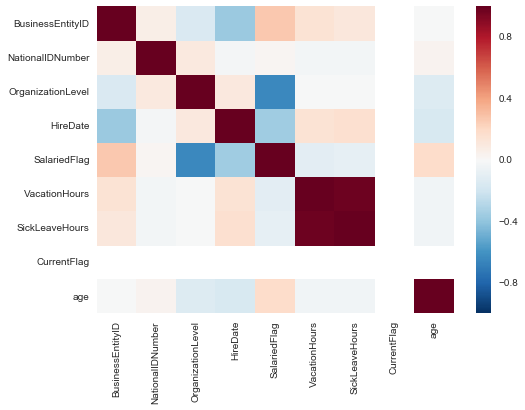

In [24]:
# Heat map of correlation matrix
sns.heatmap(corr)

All the features are not highly correlated but correlated features do also exists. So if we want to use all features for predictive modeling then we need to use the models which can overcome effect of correlated features so I will be using SMV and Random Forest for this data as,

* SVM tends to assign simmilar weights to correlated features 
* Random Forest, the impact of correlation is reduced as it selects features randomly


** Analysis of  Categorial Features **

As a part of feature engineering it is good practive to convert categorial featurs to number if possibles that is,  A number is assigned to each unique category. For example replcing male by 0 and female by 1. 

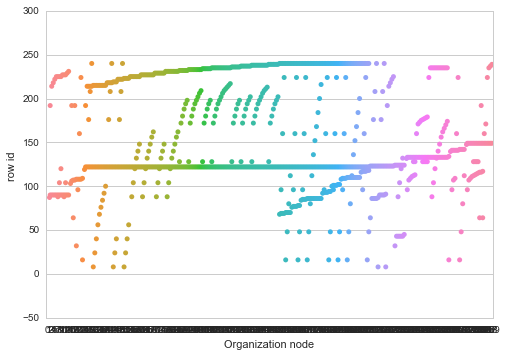

In [25]:
# Analysis of Categorial Features ('Organization Node')
sns.stripplot( data=df['OrganizationNode']);
plt.xlabel('Organization node')
plt.ylabel('row id ')
# Plotting this plot to see if some trend exists 

Organization node is also randomized and has multiple values for some employees so this feature should not be used as this can hinder the performance o model


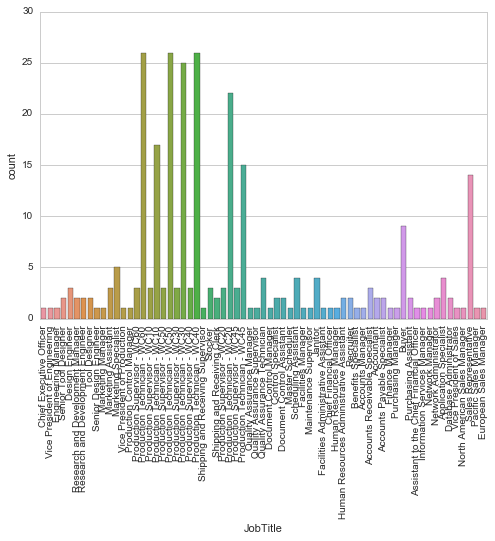

In [26]:
# Analysis of Categorial Feature ('JobTitle')
sns.countplot(x='JobTitle', data=df)
plt.xticks(rotation = 'vertical')
plt.figure(figsize=(20,10))

Most of the Job titiles have count less than 5.

In [27]:
#As there some job titles high freequency so looking at only top 10 of them 
df['JobTitle'].value_counts()[:10]

Production Technician - WC60    26
Production Technician - WC40    26
Production Technician - WC50    26
Production Technician - WC30    25
Production Technician - WC20    22
Production Technician - WC10    17
Production Technician - WC45    15
Sales Representative            14
Buyer                            9
Marketing Specialist             5
Name: JobTitle, dtype: int64

In [28]:
# Analysis of Categorial Features ('Organization Node')
df['MaritalStatus'].value_counts()

M    146
S    144
Name: MaritalStatus, dtype: int64

In [29]:
# Converting String categories to number, Married = 0 and Single = 1
decision_dict = {'M': 0, 'S': 1}
df['MaritalStatus'] = (df['MaritalStatus'].map(decision_dict))

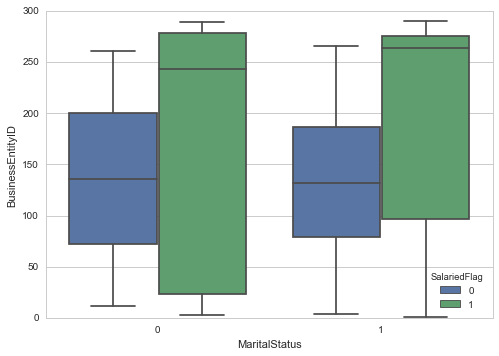

In [30]:
# Box plot of Marital Status and BusinessEntityID. Business Entity Id is the continous unique id for employees
ax = sns.boxplot(y="BusinessEntityID", x="MaritalStatus", data=df,hue = "SalariedFlag")

For both the marital status non salaried are evenly distributed where as salaried are not evenly distributed(range of marital status 1 and salaried flag1 is less as compared to marital status 0)

In [31]:
# Looking at the distribution of Gender across data
df['Gender'].value_counts()

M    206
F     84
Name: Gender, dtype: int64

In [32]:
# Converting String categories to number, Male = 0 and Female = 1
decision_dict = {'M': 0, 'F': 1}
df['Gender'] = (df['Gender'].map(decision_dict))

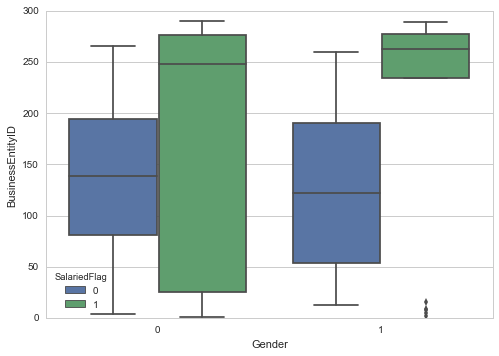

In [33]:

# Box plot of Gender and BusinessEntityID. Business Entity Id is the continous unique id for employees
ax = sns.boxplot(y="BusinessEntityID", x="Gender", data=df,hue = 'SalariedFlag')

There is big mismatch in Distribution of gender for salaried flag 1. This implies that this feature will have high impact on the decision making of the model.
For the salaried Flag 0 gender distribution is evenly spread 

In [34]:
# Looking at the distribution of Salaried Flag across data
df['SalariedFlag'].value_counts()

0    238
1     52
Name: SalariedFlag, dtype: int64

In [35]:
# Looking at the values of current flag
df['CurrentFlag'].value_counts()

1    290
Name: CurrentFlag, dtype: int64

So all the employees in the table are current flag. This feature will not be impacting the predictive model. This feature can be removed in feature engineering phase only if it is confirmed that this feature always has value 1. However it is not mentioned and hence we can expect this to have value other than one in future so not removing this feature

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290 entries, 0 to 289
Data columns (total 15 columns):
BusinessEntityID     290 non-null int64
NationalIDNumber     290 non-null int32
LoginID              290 non-null object
OrganizationNode     290 non-null object
OrganizationLevel    290 non-null int64
JobTitle             290 non-null object
BirthDate            290 non-null object
MaritalStatus        290 non-null int64
Gender               290 non-null int64
HireDate             290 non-null int32
SalariedFlag         290 non-null int32
VacationHours        290 non-null int64
SickLeaveHours       290 non-null int64
CurrentFlag          290 non-null int32
age                  290 non-null int32
dtypes: int32(5), int64(6), object(4)
memory usage: 28.4+ KB


** Data Prepration **

Creating new data frame dfOtherTrain for training the supervised learning model using the other(non-date and non id) features only

In [37]:
dfOtherTrain  = df[['OrganizationLevel','JobTitle','MaritalStatus','Gender','VacationHours','SickLeaveHours','CurrentFlag']]

AS  only very few columns/features are still not numeric so using Vectorization technique to create new vectorized data that will be used for predictive models

Technique used: DictVectorization, This transformer turns lists of mappings (dict-like objects) of feature names to feature values into Numpy arrays or scipy.sparse matrices for use with scikit-learn estimators.  ~ Source: sklean

In [38]:
# using dictvectorization
dv = DictVectorizer(sparse=False) 
dfTransform = pd.DataFrame(dfOtherTrain).convert_objects(convert_numeric=True)
df_transform = dv.fit_transform(dfTransform.to_dict(orient='records'))

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  app.launch_new_instance()


### Applying Supervised Learning Models


* Using SVM and Random forest supervised learning models to predict salried flag
* Using Scikit-Learn for machine learning models
* For each model the performance evaluation is done using accuracy,AUC and confussion matrix 

*Not using precision and recall as both will be ver efficient in this scenario to see efficiency of model

Accuracy: number of correctly predicted/total number of labels

AUC: Compute area under curve from prediction score. Hiigher the better

Confussion Matrix: Matrix that shows the expected and predicted score of each label


In this task we need to apply supervised machine learning models and fine tune the hyperparameters of the models by extensive grid search. While evaluating hyper parameters there is risk of overfitting on the test data as parameters will be tunned till untill model performs optimally. This way there are chances that the test data can leak into the model and evaluation matrix does not report on genralization performance. To solve this problem I am deviding dataset into 3 parts, Train,validate and test. The training of model is performed on train data , evaluation and performance tunning by changing hyper parameters is done on validation data and finally the model is tested on test dataset.
As in this task the data consists of only 290 rows. So partitioning data into 3 parts(percentage 65:25:10) will drastically reduce data and result might depend on random choices for pair of train and validation dataset. 
Asolution to this problem is applying K-Fold Cross validation. In this process the test set is kept held out for the final evaluation and validation set is not required. In this process the model is trained k-1 times and resulted model is validated using the test data kept aside. 

The performance reported by k-fold CV is the average of values computed during complete process.


** Split the data set into 70:30 **

In [39]:
# Splitting data into train and test datasets for tunning the parameters and testing the model.
# The test data X_test will be set apart during training phase and will only be used for testing model (after hyper parameters)

X_train, X_test, y_train, y_test = train_test_split(df_transform,df.SalariedFlag, test_size=0.3, random_state=1)

In [40]:
# Cross validation iterator for training and validation of model 
cv = ShuffleSplit(X_train.shape[0], n_iter=10, test_size=0.2, random_state=0)

### SVC - Support vector Classifier  

***Given labeled training data, the algorithm outputs an optimal hyperplane which categorizes new examples ***

To Begin with, Applying using SVM model with the default parameters.

In [41]:
# training and testing SVM classifier(SVC) model
start_time = time.time()
svc = SVC()
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
end_time = time.time()
print("Accuracy reported by SVM with linear kernel  =", 1.0*sum(y_test==y_pred)/len(y_pred))
print("ROC AUC reported  by SVM with linear kernel =", roc_auc_score(y_test, y_pred))
print ("Time taken to complete = %.1f mins" %((end_time-start_time)/60.00))



('Accuracy reported by SVM with linear kernel  =', 0.7816091954022989)
('ROC AUC reported  by SVM with linear kernel =', 0.5)
Time taken to complete = 0.0 mins


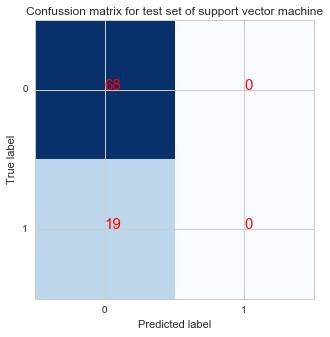

In [42]:
# Plotting the confussion matrix for SVM results.
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(5,5))
ax.imshow(cm, interpolation='nearest', cmap='Blues')
for i, line in enumerate(cm):
    for j, l in enumerate(line):
        ax.text(j, i, l, size=15, color='red')
ax.set_xticks(range(len(cm)))
#ax.set_xticklabels(labels,rotation='vertical')
ax.set_yticks(range(len(cm)))
#ax.set_yticklabels(labels)
ax.set_ylabel('True label')
ax.set_xlabel('Predicted label')
ax.set_title('Confussion matrix for test set of support vector machine')
plt.show()

According to confussion matrix, using the SVM with default parameters 8 labels are predicted wrong and all 8 are label 1

Hyper parameters of SVM are C and gamma

Using extensive ** grid search  ** over C and gamma hyper parameters to find the best performing model

Hyperparameter C : Penalty parameter C of the error term

Hyperparameter gamma: Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’



** Putting this model in cross validation iterator **

In [43]:
# Building model with parameter grid
svc = GridSearchCV(SVC(kernel='rbf',), cv=cv,
            param_grid={"C": np.linspace(2**(-15),2**(15),50),
                               "gamma": np.logspace(-2, 2,5)})


In [44]:
#Training and testing of SVC using the above mentioned parameter grid
start_time = time.time()
svc.fit(X_train, y_train)
svc_fit = time.time() - start_time
y_pred = svc.predict(X_test)
print ('Time to complete = ', svc_fit)
print (' ')
print (svc.best_score_)
print ('')
print (svc.best_estimator_)
print ('')
print (svc.best_params_)

('Time to complete = ', 26.376999855041504)
 
0.948780487805

SVC(C=668.73472377232144, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

{'C': 668.73472377232144, 'gamma': 0.01}


Using the best parameters(after grid search) to test the model's accuracy, precision, recall and confussion matrix using the X_test data which was left apart(was never used during any phase of training) for only testing.

In [45]:
# Using the best parameters
start_time = time.time()
svm = svc.best_estimator_
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
end_time = time.time()
print("Accuracy reported by SVM with linear kernel  =", 1.0*sum(y_test==y_pred)/len(y_pred))
print("ROC AUC reported  by SVM with linear kernel =", roc_auc_score(y_test, y_pred))
print ("Time taken to complete = %.1f mins" %((end_time-start_time)/60.00))



('Accuracy reported by SVM with linear kernel  =', 0.9425287356321839)
('ROC AUC reported  by SVM with linear kernel =', 0.86842105263157898)
Time taken to complete = 0.0 mins


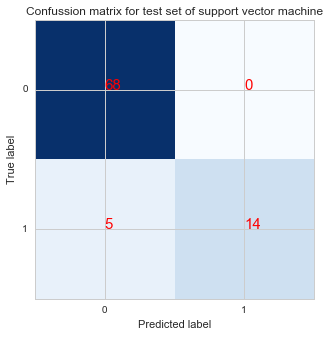

In [46]:
# Plotting the confussion matrix for SVM results.
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(5,5))
ax.imshow(cm, interpolation='nearest', cmap='Blues')
for i, line in enumerate(cm):
    for j, l in enumerate(line):
        ax.text(j, i, l, size=15, color='red')
ax.set_xticks(range(len(cm)))
#ax.set_xticklabels(labels,rotation='vertical')
ax.set_yticks(range(len(cm)))
#ax.set_yticklabels(labels)
ax.set_ylabel('True label')
ax.set_xlabel('Predicted label')
ax.set_title('Confussion matrix for test set of support vector machine')
plt.show()

The results of the model on set apart X_test data are quite good that is accuracy score of 0.94 and AUC = 0.86

** Plotting Learning Curve for SVM **
For n_iter = 10 X_train is randomly split into a training and a test set 10 times (n_iter=10). Each point on Training score curve (red color) is the average score of training and evluation of model on ith iteration.Each point on the cross-validation score curve(Green color) is the average of scores when model was trained on training examples and tested on all the records

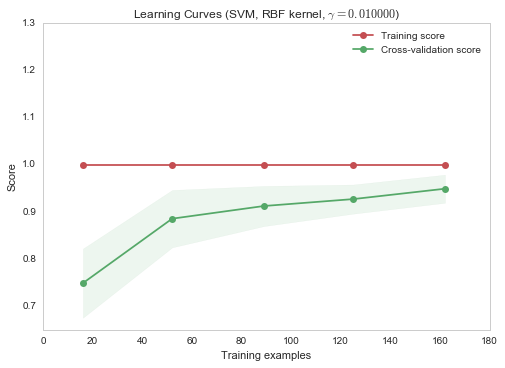

In [47]:
# Using sklearn function standard function to visualize learning curves to see 
title = "Learning Curves (SVM, RBF kernel, $\gamma=%.6f$)" %svc.best_estimator_.gamma
# SVC is more expensive so we do a lower number of CV iterations:
cv = cross_validation.ShuffleSplit(X_train.shape[0], n_iter=10,
                                   test_size=0.2, random_state=0)
estimator = svc.best_estimator_
plot_learning_curve(estimator, title, X_train, y_train,(0.65,1.3), cv=cv, n_jobs=4)

plt.show()



** Comparison of SVC with tunned hyper parameters vs SVC with default parameters **

SVC model using the best estimators performed much better then the default model.
The accuracy score improved from 0.78 to 0.94 and AUC from 0.5 to 0.86. The improvement is also visible in confussion matrixsas in default non of label 1 was predivceted correct where as after fitting model with best estimators it has correctly identified 14 label 1

### Random Forest Model 

*** Random forest is ensemble learning model that works by constructing multitude of decision tree ***

Training  random forest with default parameters

In [48]:
# First running random forest with default parameters
start_time = time.time()
rmf = RandomForestClassifier()
rmf.fit(X_train, y_train)
predictions_rmf = rmf.predict(X_test)
end_time = time.time()
print("Accuracy reported by Random Forest  =", 1.0*sum(y_test==predictions_rmf)/len(predictions_rmf))
print("ROC AUC reported  by random forest =", roc_auc_score(y_test, y_pred))
print ("Time taken to complete = %.1f mins" %((end_time-start_time)/60.00))

('Accuracy reported by Random Forest  =', 0.9080459770114943)
('ROC AUC reported  by random forest =', 0.86842105263157898)
Time taken to complete = 0.0 mins


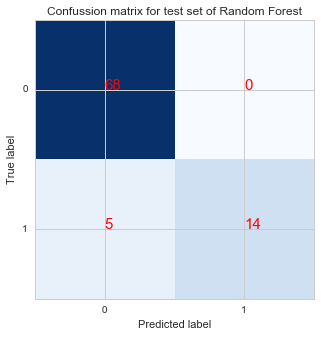

In [49]:
# Plotting the confussion matrix for SVM results.
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(5,5))
ax.imshow(cm, interpolation='nearest', cmap='Blues')
for i, line in enumerate(cm):
    for j, l in enumerate(line):
        ax.text(j, i, l, size=15, color='red')
ax.set_xticks(range(len(cm)))
#ax.set_xticklabels(labels,rotation='vertical')
ax.set_yticks(range(len(cm)))
#ax.set_yticklabels(labels)
ax.set_ylabel('True label')
ax.set_xlabel('Predicted label')
ax.set_title('Confussion matrix for test set of Random Forest')
plt.show()

In [50]:
# Defining parameter grid for random forest
param_grid = {"n_estimators" :[1,5,10,50],
              "max_features": [1,5,10,15,20,25,30,35,40,50,60,70]}
# preparing model - random forest
rbf = GridSearchCV(RandomForestClassifier(), cv=cv,param_grid=param_grid)

In [51]:
# Model fit and testing the model's accuracy 
start_time = time.time()
rbf.fit(X_train, y_train)
rbf_fit = time.time() - start_time
y_pred = rbf.predict(X_test)
print ('Time to complete = ', rbf_fit)
print (' ')
print (rbf.best_score_) 
print ('')
print (rbf.best_estimator_)
print ('')
print (rbf.best_params_)

('Time to complete = ', 29.080000162124634)
 
0.975609756098

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=60, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

{'max_features': 60, 'n_estimators': 50}


In [52]:
# fitting the model with best estimators/hyper parameters
start_time = time.time()
rfm = rbf.best_estimator_
rfm.fit(X_train, y_train)
predictions_rfm = rfm.predict(X_test)
end_time = time.time()
print("Accuracy reported by random forest  =", 1.0*sum(y_test==predictions_rfm)/len(predictions_rfm))
print("ROC AUC reported  by random forest =", roc_auc_score(y_test, y_pred))
print("Time taken to complete = %.1f mins" %((end_time-start_time)/60.00))


('Accuracy reported by random forest  =', 0.9195402298850575)
('ROC AUC reported  by random forest =', 0.86106811145510842)
Time taken to complete = 0.0 mins


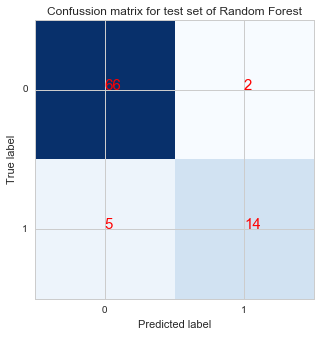

In [53]:
# Plotting the confussion matrix for Random Forest results.
cm = confusion_matrix(y_test, predictions_rfm)
fig, ax = plt.subplots(figsize=(5,5))
ax.imshow(cm, interpolation='nearest', cmap='Blues')
for i, line in enumerate(cm):
    for j, l in enumerate(line):
        ax.text(j, i, l, size=15, color='red')
ax.set_xticks(range(len(cm)))
#ax.set_xticklabels(labels,rotation='vertical')
ax.set_yticks(range(len(cm)))
#ax.set_yticklabels(labels)
ax.set_ylabel('True label')
ax.set_xlabel('Predicted label')
ax.set_title('Confussion matrix for test set of Random Forest')
plt.show()

** Plotting Learning Curve for Random Forest **
For n_iter = 10 X_train is randomly split into a training and a test set 10 times (n_iter=10). Each point on Training score curve (red color) is the average score of training and evluation of model on ith iteration.Each point on the cross-validation score curve(Green color) is the average of scores when model was trained on training examples and tested on all the records

<module 'matplotlib.pyplot' from 'C:\Anaconda2\lib\site-packages\matplotlib\pyplot.pyc'>

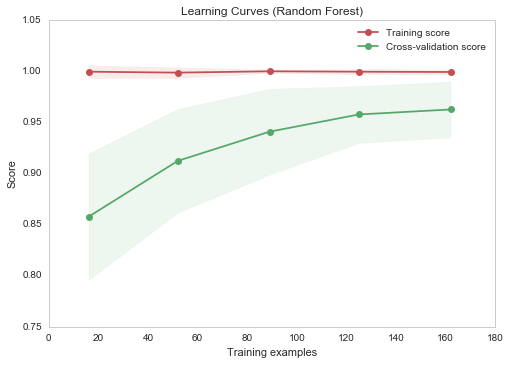

In [54]:
# Plotting learning curves for random forest
title = "Learning Curves (Random Forest)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = cross_validation.ShuffleSplit(X_train.shape[0], n_iter=100,
                                   test_size=0.2, random_state=0)

estimator =rbf.best_estimator_
plot_learning_curve(estimator, title, X_train, y_train,  cv=cv, n_jobs=4)


** Comparison of Random forest with tunned hyper parameters vs default parameters **

Fitting Random forest with best estimators has not shown much improvement from the default random forest. with default random forst the accuracy and AUC score was 0.90 and 0.86 where as afterperforming grid search the best estimator model is giving accuracy of 0.91 and AUC score of 0.86

** Training better model on entire dataset **

The performance of both the models are very similar. SVM is performing better then Random forest as out of 3 evaluation parameters SVM has 2 parameters better then random forest (AUC and Confussion matrix)

Traning SVM classifier on entire datset.


In [55]:
# Training using entire datset
svm = svc.best_estimator_
svm.fit(df_transform, df['SalariedFlag'])
end_time = time.time()
